# hyper parameter optimization, slutsatser
## datum har visat sig vara användbart
## skall vara med som cat_feature, inte numerisk
## default depth=6 är bra medan l2_leaf_reg=2 verkar bättre än default 1
## Det går aldeles utmärkt med None i cat_features

In [24]:
!pip install -U catboost --user
import pandas as pd 
import numpy as np 
from catboost import CatBoostClassifier,Pool,cv,utils

Requirement already up-to-date: catboost in c:\programdata\anaconda3\lib\site-packages (0.25.1)


In [12]:
def check_unique(df):
    for feat in df:
        if len(df[feat].unique())==1:
            df.drop(feat,axis=1,inplace=True)
    return df       

def check_corr(df):
    df.corr()
    return df

def remove_features(df,remove_mer=[]):
    #remove_mer=['h5_perf','h5_auto','h4_perf','h4_auto', 'h3_perf', 'h2_perf']
    df.drop(['avd','vodds','podds','h1_dat','h2_dat','h3_dat','h4_dat','h5_dat'],axis=1,inplace=True) #
    if remove_mer:
        df.drop(remove_mer,axis=1,inplace=True)
    
    df=check_unique(df.copy())
    df=check_corr(df.copy())
    return df

In [13]:
### Spara max av Recall, F1, AUC etc till efter learning
def spara(model,test_pool,results):
    dic=model.eval_metrics(test_pool,['Recall','F1','AUC','Accuracy','Precision'])
    dic['best']=model.get_feature_importance(prettified=True)['Feature Id'][0]
    dic['worst']=model.get_feature_importance(prettified=True)['Feature Id'].iloc[-1]
    results.loc[len(results),:]=[None,None,None,None,None,None,None]
    results.loc[len(results)-1,:] = [np.max(dic['Recall']),np.max(dic['F1']),np.max(dic['AUC']),np.max(dic['Accuracy']),np.max(dic['Precision']),dic['best'],dic['worst']]
    print('       Recall  F1   AUC   Precision Accuracy')
    print('mean:',round(np.mean(results['Recall']),4),round(np.mean(results['F1']),4),round(np.mean(results['AUC']),4),
          round(np.mean(results['Accuracy']),4),round(np.mean(results['Precision']),4))
    print('std: ',round(np.std(results['Recall']),4),round(np.std(results['F1']),4),round(np.std(results['AUC']),4),
          round(np.std(results['Accuracy']),4),round(np.std(results['Precision']),4))
    print(f"best={dic['best']} worst={dic['worst']}")
    return results


In [14]:
def handle_cat_features(df,cat):
    # for c in cat:
    #     df.loc[df[c].isna()][c] = 'UNK'  - kolla om nan kan användas

    # df['start']=(df.start=='AUTOSTART').astype(bool)  - behövs inte
    return df

In [15]:
## För att testa varför Datum får sådan påverkan delar jag upp i delar
def dela_datum(df):
    split=df.datum.str.split('-')
    df['år']=split.apply(lambda x: x[0])
    df['mån']=split.apply(lambda x: x[1])
    df['dag']=split.apply(lambda x: x[2])
    
    return df.drop('datum',axis=1)

In [16]:
### split så att allt fram till split_dat blir train och endast en split_dat (en omgång) blir test ###
def one_split(df,split_dat):

    print(f'len(df)={len(df)}')
    
    X_train = df.loc[df.datum<fr_dat].copy()
    y_train = X_train.plac==1
    X_train.drop(['datum','plac'],axis=1,inplace=True)
    X_test = df.loc[df.datum==fr_dat].copy()
    y_test = X_test.plac==1
    X_test.drop(['datum','plac'],axis=1,inplace=True)
    return X_train,X_test,y_train,y_test


In [17]:
df=pd.read_csv('all_data.csv')
df.sort_values(by=['datum','avd'],inplace=True)
df=remove_features(df.copy())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40104 entries, 0 to 40103
Data columns (total 59 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datum      40104 non-null  object 
 1   bana       40104 non-null  object 
 2   häst       40104 non-null  object 
 3   kusk       40104 non-null  object 
 4   streck     40104 non-null  int64  
 5   kr         40104 non-null  int64  
 6   spår       40015 non-null  float64
 7   dist       40104 non-null  int64  
 8   lopp_dist  40104 non-null  int64  
 9   start      40104 non-null  int64  
 10  ålder      40104 non-null  int64  
 11  kön        40104 non-null  object 
 12  plac       40104 non-null  int64  
 13  pris       40104 non-null  float64
 14  h1_kusk    40104 non-null  object 
 15  h1_bana    40104 non-null  object 
 16  h1_dist    40104 non-null  float64
 17  h1_auto    40104 non-null  bool   
 18  h1_spår    37174 non-null  float64
 19  h1_plac    40012 non-null  float64
 20  h1_pri

In [18]:
### train test split med tanke på datum ###
### för 'vanlig' körning ###
def split_data(df,sort=False,numDat=False):
    df['plac']=(df.plac==1)*1    # vann eller ej
    alla_datum = df.datum.unique()
    split_ix = int(len(alla_datum)*0.75)
    split_datum = alla_datum[split_ix]
    print(split_datum)
    X_train = df.loc[df.datum<split_datum,:].copy()
    X_test = df.loc[df.datum >= split_datum,:].copy()
    if sort:
        X_train=X_train.sample(frac=1)

    if numDat:
        X_train['datum'] = X_train.datum.str.replace('-','').astype(float)
        X_test['datum'] = X_test.datum.str.replace('-','').astype(float)

    y_train = X_train.plac; X_train.drop(['plac'],axis=1,inplace=True)
    y_test  = X_test.plac;  X_test.drop(['plac'],axis=1,inplace=True)
    return X_train,X_test,y_train,y_test

## Ett par funktioner för "vanlig" train/test

In [19]:
def run_train_test(X_train,X_test,y_train,y_test,cat_features,metric='Accuracy'):
    train_pool=Pool(X_train,y_train,cat_features=cat_features)
    test_pool =Pool(X_test, y_test, cat_features=cat_features)
    
    model = CatBoostClassifier(iterations=3000,
            use_best_model=True, 
            eval_metric=metric, 
            auto_class_weights='Balanced',
            verbose=100, l2_leaf_reg=2, 
            random_state=2021)

    model.fit(X_train,y=y_train,cat_features=cat_features,
        eval_set=(X_test,y_test),early_stopping_rounds=150
    )
    return model

In [20]:
def meassure(model,X_test,y_test,cat_features,meas_df=None):
    test_pool = Pool(X_test,y_test,cat_features=cat_features)
    # utils.get_confusion_matrix(model,test_pool)
    eval_dic = model.eval_metrics(test_pool,['Recall','F1','Accuracy','AUC','Precision'])
    print(f"Recall={round(np.max(eval_dic['Recall']),3)} F1={round(np.max(eval_dic['F1']),3)} Acc={round(np.max(eval_dic['Accuracy']),3)} AUC={round(np.max(eval_dic['AUC']),3)} Precision={round(np.max(eval_dic['Precision']),3)}")
    if meas_df:
        pass  # (tills vidare)


In [21]:
### Kör standard train_test ###
cat_features =[]
def standard_train_test(df): 
    global cat_features
    X_train,X_test,y_train,y_test = split_data(df,sort=False,numDat=False)
    #X_train,X_test,y_train,y_test = split_data(df.drop('streck',axis=1))
    print(X_train.datum.max(),X_test.datum.min())
    # X_train = dela_datum(X_train.copy())
    # X_test = dela_datum(X_test.copy())
    # X_train['år']=X_train.mån.astype(int)
    # X_test['år']=X_test.mån.astype(int)
    # X_train['mån']=X_train.mån.astype(int)
    # X_test['mån']=X_test.mån.astype(int)
    # X_train['dag']=X_train.mån.astype(int)
    # X_test['dag']=X_test.mån.astype(int)
    # X_train.drop('datum',axis=1,inplace=True);X_test.drop('datum',axis=1,inplace=True)
    cat_features = X_train.loc[:,X_train.dtypes=='O'].columns.to_list()
    model=run_train_test(X_train,X_test,y_train,y_test,cat_features,metric='Logloss')
    meassure(model,X_test,y_test,cat_features)
    return model
#### körs enligt:
model=standard_train_test(df.copy())
model.get_params()


2019-08-22
2019-08-21 2019-08-22


CatBoostError: Invalid type for cat_feature[non-default value idx=3078,feature_idx=31]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

### Resultat med olika eval_metric 
**Med Datum**   
Recall=0.812 F1=0.752 Acc=0.737 AUC=0.817 Precision=0.745  

**Utan Datum**  
**Precision:**  
Recall=0.778 F1=0.744 Acc=0.737 AUC=0.818 Precision=0.866  
**Recall:**  
Recall=0.778 F1=0.744 Acc=0.734 AUC=0.805 Precision=0.722  
**F1:**  
Recall=0.778 F1=0.744 Acc=0.734 AUC=0.805 Precision=0.722  
**Accuracy:**  
Recall=0.778 F1=0.744 Acc=0.736 AUC=0.816 Precision=0.728  
**AUC:**  
Recall=0.778 F1=0.744 Acc=0.734 AUC=0.816 Precision=0.722 

In [255]:
fi=model.get_feature_importance(prettified=True)
# fi.sort_values(by='Feature Id',inplace=True)
fi

,Feature Id,Importances
0,streck,65.041562
1,häst,5.668708
2,h5_bana,1.852350
3,h3_kusk,1.753427
4,kusk,1.549586
5,lopp_dist,1.423839
6,h1_kusk,1.253513
7,h3_plac,1.238885
8,h2_pris,1.156694
9,h4_bana,0.962612


In [256]:
# !pip3 install shap 
import shap
shap.initjs()

In [257]:
# X_train,X_test,y_train,y_test = split_data(df.drop('streck',axis=1))
X_train,X_test,y_train,y_test = split_data(df,numDat=True)
train_pool=Pool(X_train,y_train,cat_features=cat_features)
test_pool =Pool(X_test, y_test, cat_features=cat_features)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)

2019-08-22


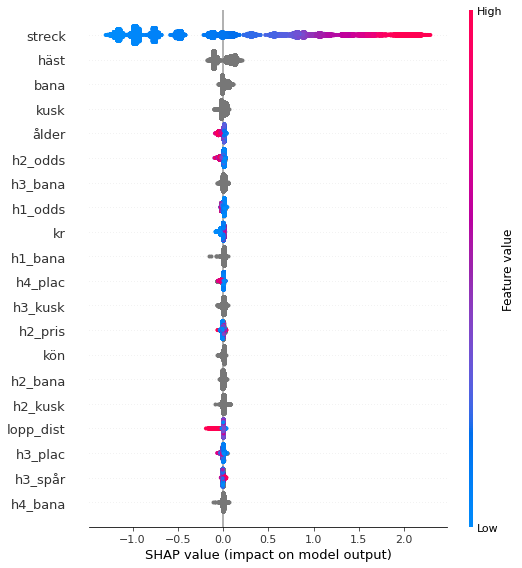

In [258]:
shap.summary_plot(shap_values, X_train)

In [259]:
# Varje datum har exakt 7 vinnare (7 lopp) och 63-100 hästar. I snitt 81 hästar per datum med 7 vinnare
# CB använder en form av "Target encoding" som använder distributionen av y som encoding av varje datum. 
# Man gör en permutation (ung. som cross validation) för att inte få en overfit som kan hända annars.
# Men här dyker ett mönster upp där permutationerna inte påverkar mycket. 
# Det finns endast ett fåtal möjliga encodade värden för varje datum baserat på antal hästar ovh antal vinnare.
# Få hästar i ett lopp ökar chansen för att hitta vinnare.
# CB föröker också kombinerea kategorier, tex kusk och häst skulle kunna vara en sådan komb men datum 
# kan kanppast slås ihop med någon annan kategori.
# värdet för varje datum blir (countInClass+prior)/(totalCount+1) där prior är en konstant som sätts eller beräknas först.
# Eftersom vi har ett obalanserat data så använder jag en inbyggd viktning 
# auto_class_weights='Balanced' och jag inte vet hur det påverkar CB's hantering av kategorier.
# Test har ju bara okända datum och då blir värdet prior/(totalCount+1). prior och totalCount som ovan för train.
# Det finns iallafall ett mönster som kan ge utfall.
df.groupby('datum').häst.count().mean()

81.34685598377283

-------
# Nu följer hyperparm optimering av depth och 

In [63]:
def spara(model,fas,X_test,y_test,cat_features,results):
    test_pool = Pool(X_test,y_test,cat_features=cat_features)
    dic=model.eval_metrics(test_pool,['Recall','F1','AUC','Accuracy','Precision'])
    results.loc[len(results),:]=[None,None,None,None,None,None]
    results.loc[len(results)-1,:] = [fas,np.max(dic['Recall']),np.max(dic['F1']),np.max(dic['AUC']),np.max(dic['Accuracy']),np.max(dic['Precision'])]
    results.to_csv('results_hyperparms.csv',index=False)
    return results


In [64]:
def get_startdatum(df,proc=0.75):
    alla_datum = df.datum.unique()
    split_ix = int(len(alla_datum)*proc)
    # split_datum = alla_datum[split_ix]
    # print(split_datum)
    return alla_datum,split_ix


In [65]:
def spara_feature_importance(df_fi,fi,init=False):
    df_fi.sort_values(by='Feature Id',inplace=True)
    fi.sort_values(by='Feature Id',inplace=True)
    nr=len(df_fi.columns)
    if init:
        df_fi=fi.copy()
    else:
        df_fi['Importances'+str(nr)] = fi.Importances.copy()

    return df_fi.copy()

In [176]:
def get_model(d,l2):
    model = CatBoostClassifier(iterations=3000,use_best_model=True, eval_metric='Accuracy', 
             depth=d,l2_leaf_reg=l2,
             auto_class_weights='Balanced',verbose=False, random_state=2021) 
    return model                

In [108]:
### Kör en egen grid search för parametrarna nedan här 
depths=[6]  #[6,8,10]
l2_leaf_regs=[2]    #[1,5]    #[10,20,30]
init=True
# results=pd.DataFrame(columns=['fas','Recall','F1','AUC','Accuracy','Precision'])
df_fi = pd.DataFrame(columns=['Feature Id','Importance'])   
alla_datum,split_ix = get_startdatum(df.copy())
df['plac']=(df.plac==1)*1

for d in depths:
    for l2 in l2_leaf_regs:
        fas = f'{d}-{l2}'
        for nr,datum in enumerate(alla_datum[split_ix:]):
            print(f'{nr+1} av {len(alla_datum[split_ix:])} fas: {fas} ')
            X_train = df.loc[df.datum<datum,:].copy()
            y_train = X_train.plac; X_train.drop(['plac'],axis=1,inplace=True)
            X_test  = df.loc[df.datum==datum,:].copy()
            y_test  = X_test.plac;  X_test.drop(['plac'],axis=1,inplace=True)
            
            # X_train = dela_datum(X_train.copy())
            # X_test  = dela_datum(X_test.copy())
            
            model=get_model(d,l2)
            cat_features = X_train.loc[:,X_train.dtypes=='O'].columns
            model.fit(X_train,y=y_train,cat_features=cat_features,use_best_model=True,
                    eval_set=(X_test,y_test),early_stopping_rounds=100)

            results=spara(model,fas,X_test,y_test,cat_features,results) 
            fi=model.get_feature_importance(prettified=True)
            df_fi = spara_feature_importance(df_fi,fi,init)
            init=False
# print(df_fi.sum())

)	total: 10.1s	remaining: 4m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7407431595
bestIteration = 0

Shrink model to first 1 iterations.
124 av 124 fas: 6-2 
0:	learn: 0.7377314	test: 0.7667553	best: 0.7667553 (0)	total: 94.3ms	remaining: 4m 42s
100:	learn: 0.7582381	test: 0.7345371	best: 0.7770577 (5)	total: 10.3s	remaining: 4m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7770576682
bestIteration = 5

Shrink model to first 6 iterations.
   Feature Id  Importances  Importances2  Importances3  Importances4  \
6        bana     0.000000      1.021514      0.000000      1.014724   
5       datum     0.000000      1.235484      0.000000      1.323224   
11       dist     0.000000      0.732814      0.000000      0.656525   
20    h1_auto     0.000000      0.437361      0.000000      0.437832   
18    h1_bana     0.000000      0.579321      0.000000      0.496026   
19    h1_dist     0.000000      0.467176      0.000000      0.44178

In [236]:
fi=0
fi_columns = df_fi.iloc[:,1:].columns
for c in fi_columns:
    fi+=df_fi[c]


df_fi['tot']=fi/len(fi_columns)
df_fi[['Feature Id','tot']].sort_values(by='tot',ascending=False)

,Feature Id,tot
0,streck,83.507028
1,h3_odds,3.690802
2,h5_bana,2.366259
3,h4_kmtid,1.320278
4,h4_pris,0.921841
5,datum,0.659935
6,bana,0.527935
7,häst,0.467795
8,kusk,0.415405
9,kr,0.380752


In [76]:
# results = pd.read_csv('results_hyperparms.csv')
results=results.drop_duplicates()
results

,fas,Recall,F1,AUC,Accuracy,Precision
0,6-1,0.714286,0.745129,0.800193,0.755815,0.778756
1,6-1,0.714286,0.705314,0.760952,0.703733,0.696564
2,6-1,0.714286,0.719739,0.751931,0.722012,0.725277
3,6-1,0.857143,0.790618,0.811301,0.761851,0.733676
4,6-1,0.857143,0.771336,0.785714,0.751114,0.705833
...,...,...,...,...,...,...
3019,6-2,0.857143,0.821505,0.894035,0.832906,0.788713
3020,6-2,0.857143,0.800832,0.836190,0.788147,0.779126
3021,6-2,0.857143,0.795816,0.830688,0.789896,0.742680
3022,6-2,0.857143,0.771667,0.788610,0.746211,0.701693


In [135]:
# results=pd.read_csv('results_hyperparms.csv')
results.drop_duplicates()
results.dropna(inplace=True)
results[results.fas.str.contains('')].groupby('fas').mean().sort_values(by='Accuracy',ascending=False)


,Recall,F1,AUC,Accuracy,Precision
fas,,,,,
6-2,0.800805,0.762735,0.814438,0.762193,0.736978
6_2,0.801843,0.749977,0.780553,0.743669,0.712349
6-10,0.799539,0.749125,0.780336,0.743521,0.712629
6-1,0.800691,0.749596,0.781081,0.743321,0.712248
10-1,0.801843,0.749451,0.783559,0.742710,0.710971
10+10,0.799539,0.748694,0.782772,0.742573,0.711211
10-2,0.800691,0.749044,0.781570,0.742415,0.711078
8-1,0.798387,0.747658,0.784330,0.742117,0.710815
10+30,0.798387,0.748147,0.783814,0.741973,0.710520


In [138]:
sum=0
for c in df_fi.columns[1:]:
    sum += df_fi[c].copy()
df_fi['summa'] = sum.copy()/(len(df_fi.columns)-1)

df_fi2 = df_fi[['Feature Id','summa']].sort_values(by='summa',ascending=False).copy() 
df_fi2

,Feature Id,summa
0,streck,83.507028
1,h3_odds,3.690802
2,h5_bana,2.366259
3,h4_kmtid,1.320278
4,h4_pris,0.921841
5,datum,0.659935
6,bana,0.527935
7,häst,0.467795
8,kusk,0.415405
9,kr,0.380752


In [ ]:
cols=df_fi.columns[0:-1]
cols
df_fi =df_fi[cols]

In [195]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,h4_spår,7.771682
1,h1_bana,5.696686
2,h3_odds,4.914054
3,kön,4.364103
4,h4_pris,3.515134
5,h2_odds,3.451368
6,datum,3.414815
7,h2_kusk,3.290462
8,h5_kusk,3.140992
9,h1_kusk,3.076429
